In [1]:
%matplotlib notebook

import os

import tensorflow as tf
from tensorflow import keras

import numpy as np
import scipy as sp
import nibabel as nib
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
n = 64
batch_size = 100

# Set up model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n,n,2)),
    keras.layers.Dense(2*(n**2), activation=tf.nn.tanh),
    keras.layers.Dense(n**2, activation=tf.nn.tanh),
    keras.layers.Dense(n**2),
    keras.layers.Reshape((n,n,1)),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2DTranspose(1, (7,7), strides=(1,1), data_format='channels_last', padding='same')
    ])
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
model.load_weights('training/automap64/cp-0200.ckpt')

In [3]:
def idftmtx(N):
    return sp.ifft(sp.eye(N))

In [4]:
# Put single img_array into (batch_size,width,height,num_channels) format:
def batch_img(img_array):
    return np.expand_dims(np.expand_dims(img_array,0),-1)

# Generate k-space network input
def get_fft(img_array):
    img_fft = np.fft.fft2(img_array)
    img_fft_re = np.real(img_fft)
    img_fft_im = np.imag(img_fft)
    return np.concatenate([img_fft_re,img_fft_im],axis=3)

<IPython.core.display.Javascript object>


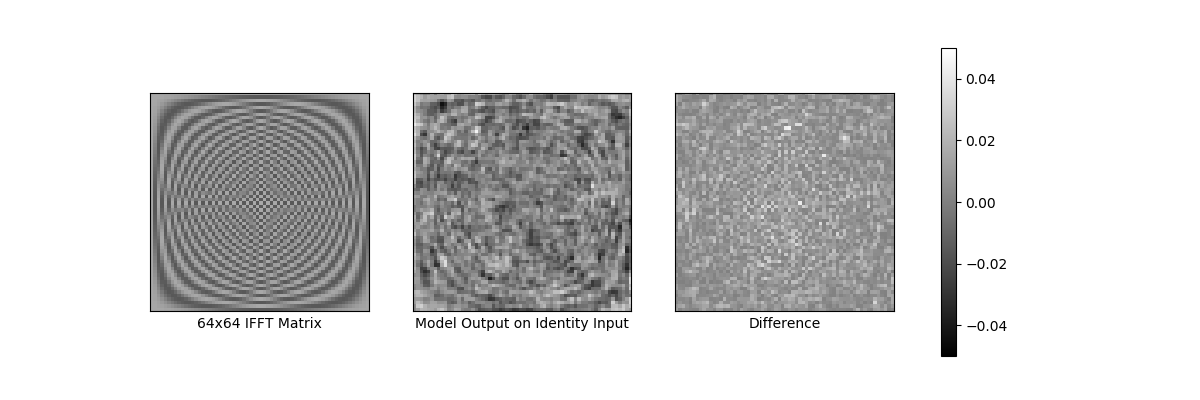

In [5]:
fig,axes = plt.subplots( 1,3, figsize=[12,4] )
for i,iax in enumerate(axes.flatten()):
    if i==0:
        true_ifft = np.real(idftmtx(64))
        im = iax.imshow(true_ifft,cmap='gray',vmin=-0.05,vmax=0.05)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('64x64 IFFT Matrix')
    elif i==1:
        identity = np.eye(64)
        identity_input = np.concatenate((batch_img(identity),batch_img(np.zeros((64,64)))),axis=3)
        identity_recon = model.predict(identity_input)[0,:,:,0]
        im = iax.imshow(identity_recon,cmap='gray',vmin=-0.05,vmax=0.05)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Model Output on Identity Input')
    elif i==2:
        im = iax.imshow(np.abs(true_ifft-identity_recon),cmap='gray',vmin=-0.05,vmax=0.05)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Difference')
        
fig.colorbar(im, ax=axes.ravel().tolist())

In [6]:
backend = keras.backend
inp = model.input               
outputs = [layer.output for layer in model.layers]
functors = [backend.function([inp, backend.learning_phase()], [out]) for out in outputs]

In [7]:
def plot_activations(input_ex,model):
    layer_outs = [func([input_ex, 1.]) for func in functors]
    
    fig = plt.figure(figsize=(54,18))

    widths = [2,2,2,4,4,2]

    spec4 = gridspec.GridSpec(1,6, width_ratios=widths,wspace=0.5)

    gs0 = gridspec.GridSpec(1,6,width_ratios=widths)

    gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0],wspace=0.0,hspace=-0.5)
    gs01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1])
    gs02 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[2])
    gs03 = gridspec.GridSpecFromSubplotSpec(8, 8, subplot_spec=gs0[3],wspace=0.0,hspace=-0.8)
    gs04 = gridspec.GridSpecFromSubplotSpec(8, 8, subplot_spec=gs0[4],wspace=0.0,hspace=-0.8)
    gs05 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[5])

    cmap='plasma'

    for i in range(8):
        if(i==0):
            pass
        elif(i==1):
            sp = fig.add_subplot(gs00[0,0])
            sp.set_xticks([])
            sp.set_yticks([])
            sp.imshow(layer_outs[1][0][0,:n**2].reshape(n,n),cmap=cmap)
            sp.set_title('FC1')
            sp = fig.add_subplot(gs00[1,0])
            sp.set_xticks([])
            sp.set_yticks([])
            sp.imshow(layer_outs[1][0][0,n**2:].reshape(n,n),cmap=cmap)
        elif(i==2):
            sp = fig.add_subplot(gs01[0,0])
            sp.set_xticks([])
            sp.set_yticks([])
            sp.imshow(layer_outs[2][0].reshape(n,n),cmap=cmap)
            sp.set_title('FC2')
        elif(i==3):
            sp = fig.add_subplot(gs02[0,0])
            sp.set_xticks([])
            sp.set_yticks([])
            sp.imshow(layer_outs[3][0].reshape(n,n),cmap=cmap)
            sp.set_title('FC3')
        elif(i==4):
            pass
        elif(i==5):
            for i in range(n):
                r = int(np.floor(i/8))
                c = i%8
                sp = fig.add_subplot(gs03[r,c])
                sp.imshow(layer_outs[5][0][0,:,:,i],cmap=cmap)
                sp.set_xticks([])
                sp.set_yticks([])
                if(i==3):
                    sp.set_title('                     Conv1')
        elif(i==6):
            for i in range(n):
                r = int(np.floor(i/8))
                c = i%8
                sp = fig.add_subplot(gs04[r,c])
                sp.imshow(layer_outs[6][0][0,:,:,i],cmap=cmap)
                sp.set_xticks([])
                sp.set_yticks([])
                if(i==3):
                    sp.set_title('                     Conv2')
        elif(i==7):
            sp = fig.add_subplot(gs05[0,0])
            sp.set_xticks([])
            sp.set_yticks([])
            sp.imshow(layer_outs[7][0][0,:,:,0].reshape(n,n),cmap=cmap)
            sp.set_title('ConvTranspose1')

In [8]:
identity = np.eye(64)
identity_input = np.concatenate((batch_img(identity),batch_img(np.zeros((64,64)))),axis=3)
plot_activations(identity_input,model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


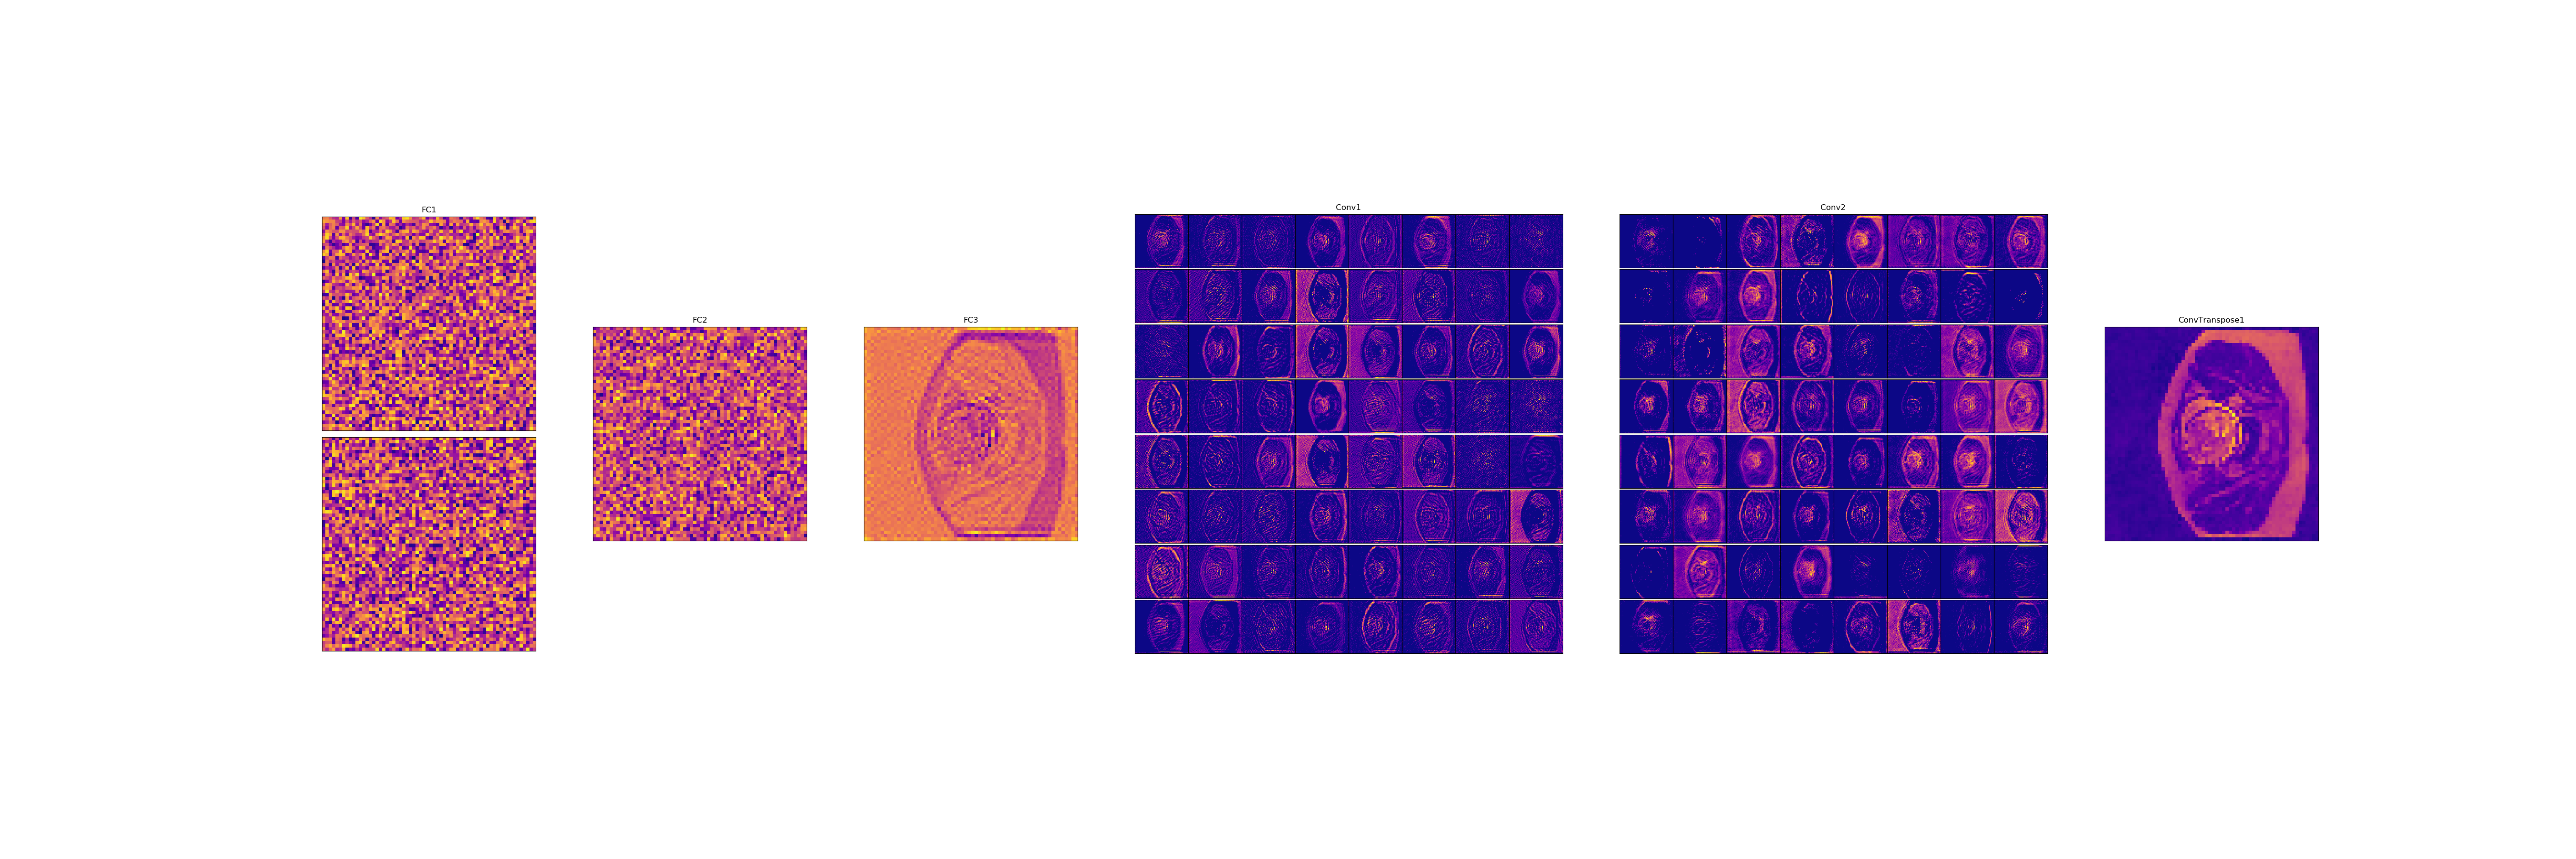

In [9]:
# Import fetal data
scannumber = 'MAP-C401-031615'
filename = 'PLACENTASTUDY_03162015_1.MR.0003_0000'
data_path = os.path.join('/data/vision/polina/projects/fetal_data/data/haste/Singleton-Control',scannumber,filename+'.nii.gz')
seg_path = os.path.join('/data/vision/polina/projects/fetal_data/data/haste/Singleton-Control-Segmentations',scannumber,filename+'-Segmentation-label.nii.gz')
img = nib.load(data_path).get_data()
sl = img[:,:,int(img.shape[2]/2)]
sl_downsample = np.array(Image.fromarray(sl).resize((n,n)))*255.0/1493.05
sl_downsample = sl_downsample-sl_downsample.mean()
sl_downsample = sl_downsample/255.
sl_k = get_fft(batch_img(sl_downsample))

plot_activations(sl_k,model)